In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torchvision import datasets

# Set the directory where you want to save the dataset
save_dir = '/content/drive/MyDrive/Classroom/train'

# Download the CelebA dataset
dataset = datasets.CelebA(root=save_dir, download=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-40fb3317d72c>", line 1, in <cell line: 1>
    import torch
  File "/usr/local/lib/python3.10/dist-packages/torch/__init__.py", line 237, in <module>
    from torch._C import *  # noqa: F403
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(

TypeError: object of type 'NoneType' has no len()

In [2]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [31]:

# load pretrained models
load_pretrained_models = True
# number of epochs of training
n_epochs = 20
# name of the dataset
dataset_path = "/content/drive/MyDrive/Classroom/train/celeba/img_align_celeba"
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.0001
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 256
# high res. image width
hr_width = 256
# number of image channels
channels = 3

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

In [30]:

# Normalization parameters for pre-trained PyTorch models

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizing data to [-1, 1]
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizing data to [-1, 1]
            ]
        )
        self.files = files

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [29]:
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True, num_workers=n_cpu)

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:16])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [32]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
mse = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()
bce = torch.nn.BCEWithLogitsLoss() # Binary Cross Entropy

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    mse = mse.cuda()
    #bce = bce.cude()
    criterion_content = criterion_content.cuda()

# Load pretrained models
if load_pretrained_models*0:
    generator.load_state_dict(torch.load("/content/drive/MyDrive/generator2.pth"))
    discriminator.load_state_dict(torch.load("/content/drive/MyDrive/discriminator2.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

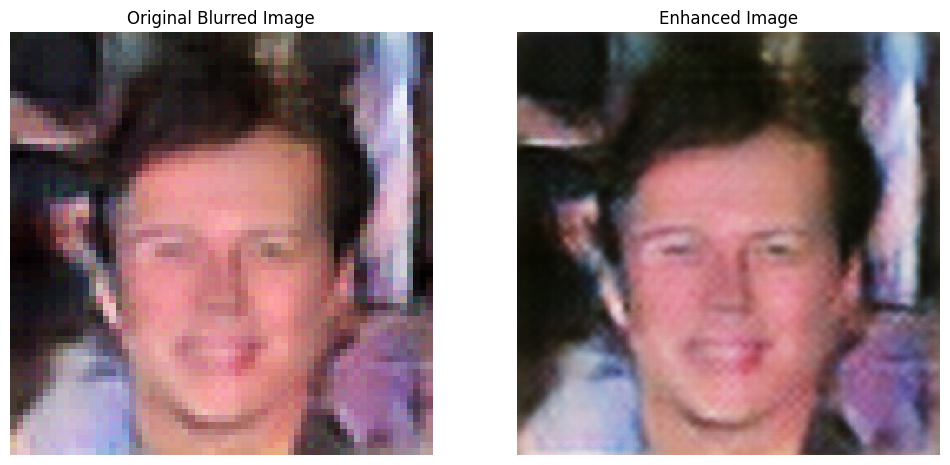

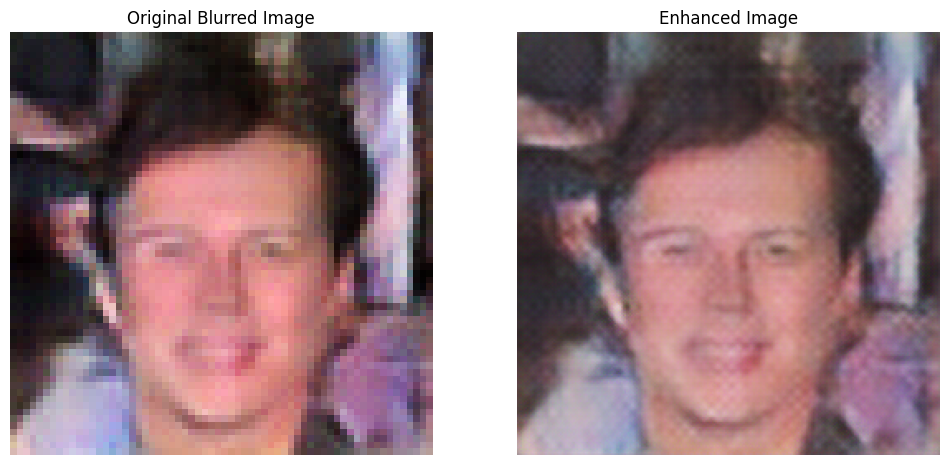

In [5]:
# prompt: write me an code that test the genrator for one image
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def enhance_image(image_path, model_path, output_path, hr_shape=(256, 256)):
    """
    Enhances a blurred image using a pre-trained generator model.

    Args:
    - image_path (str): Path to the input blurred image.
    - model_path (str): Path to the trained generator model (.pth file).
    - output_path (str): Path to save the enhanced image.
    - hr_shape (tuple): Desired output resolution of the image.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pre-trained generator model
    generator = GeneratorResNet()
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.to(device)
    generator.eval()

    # Image transformations
    transform = transforms.Compose([
        transforms.Resize((hr_shape[0] // 4, hr_shape[1] // 4), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Assuming normalization was used in training
    ])

    # Load and transform the image
    img = Image.open(image_path).convert('RGB')
    img_lr = transform(img).unsqueeze(0).to(device)

    # Generate the high resolution image
    with torch.no_grad():
        output = generator(img_lr)

    # Denormalize the output image
    output = output * 0.5 + 0.5  # Assuming [-1,1] was normalized to [0,1]

    # Convert tensor to PIL image for saving
    output = transforms.ToPILImage()(output.squeeze(0).cpu())

    # Save the enhanced image
    output.save(output_path)

    # Display the images for comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(img)
    ax1.set_title('Original Blurred Image')
    ax1.axis('off')

    ax2.imshow(output)
    ax2.set_title('Enhanced Image')
    ax2.axis('off')

    plt.show()

# Example usage
enhance_image("/content/drive/MyDrive/fake_image.png", "/content/drive/MyDrive/generator2.pth", "/content/super_resolution_image.jpg")
enhance_image("/content/drive/MyDrive/fake_image.png", "/content/drive/MyDrive/generator.pth", "/content/super_resolution_image.jpg")


In [34]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

for epoch in range(n_epochs):
    #enhance_image("/content/drive/MyDrive/1.jpg", "/content/drive/MyDrive/generator.pth", "/content/super_resolution_image.jpg")
      ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = bce(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = mse(gen_features, real_features.detach())
        # Total loss
        loss_G = 0.006*loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = bce(discriminator(imgs_hr), valid)
        loss_fake = bce(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Testing
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = bce(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = 0.006*loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = bce(discriminator(imgs_hr), valid)
        loss_fake = bce(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        # Save image grid with upsampled inputs and SRGAN outputs
        if random.uniform(0,1)<0.1:
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            save_image(img_grid, f"/content/images/{batch_idx}.png", normalize=False)

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))

    # Save model checkpoints
    if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
        torch.save(generator.state_dict(), "/content/drive/MyDrive/generator2.pth")
        torch.save(discriminator.state_dict(), "/content/drive/MyDrive/discriminator2.pth")


Training Epoch 0 :   0%|          | 0/1288 [00:00<?, ?it/s]

Testing Epoch 0 :   0%|          | 0/36 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/1288 [00:00<?, ?it/s]

Testing Epoch 1 :   0%|          | 0/36 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/1288 [00:00<?, ?it/s]

KeyboardInterrupt: 

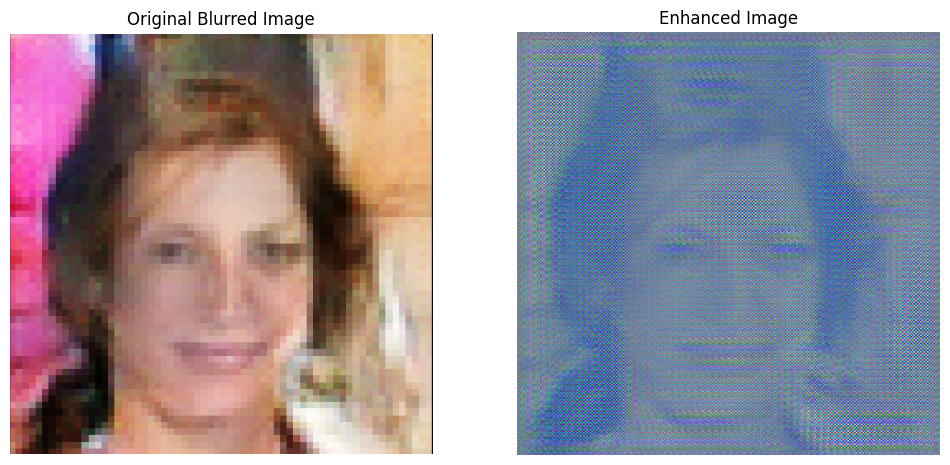

In [11]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def enhance_image(image_path, model_path, output_path, hr_shape=(256, 256)):
    """
    Enhances a blurred image using a pre-trained generator model.

    Args:
    - image_path (str): Path to the input blurred image.
    - model_path (str): Path to the trained generator model (.pth file).
    - output_path (str): Path to save the enhanced image.
    - hr_shape (tuple): Desired output resolution of the image.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pre-trained generator model
    generator = GeneratorResNet()
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.to(device)
    generator.eval()

    # Image transformations
    transform = transforms.Compose([
        transforms.Resize((hr_shape[0] // 4, hr_shape[1] // 4), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Assuming normalization was used in training
    ])

    # Load and transform the image
    img = Image.open(image_path).convert('RGB')
    img_lr = transform(img).unsqueeze(0).to(device)

    # Generate the high resolution image
    with torch.no_grad():
        output = generator(img_lr)

    # Denormalize the output image
    output = output * 0.5 + 0.5  # Assuming [-1,1] was normalized to [0,1]

    # Convert tensor to PIL image for saving
    output = transforms.ToPILImage()(output.squeeze(0).cpu())

    # Save the enhanced image
    output.save(output_path)

    # Display the images for comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(img)
    ax1.set_title('Original Blurred Image')
    ax1.axis('off')

    ax2.imshow(output)
    ax2.set_title('Enhanced Image')
    ax2.axis('off')

    plt.show()

# Example usage
enhance_image("/content/drive/MyDrive/1.jpg", "/content/drive/MyDrive/generator.pth", "/content/super_resolution_image.jpg")
